# **ANIKET NANDY 015015 Q1 NLP**

In [2]:
#Create spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("local[*]").getOrCreate()

In [3]:
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
import seaborn as sns

In [8]:
#Importing the dataset

sqlContext = SQLContext(spark)
pdf = pd.read_excel('Corona_NLP_train.xlsx')
dataset = sqlContext.createDataFrame(pdf.astype(str))
dataset = dataset.select('OriginalTweet','Sentiment')

In [16]:
#showing top 10 rows
dataset.show(10)

+--------------------+------------------+-----+
|       OriginalTweet|         Sentiment|label|
+--------------------+------------------+-----+
|@MeNyrbie @Phil_G...|           Neutral|  2.0|
|advice Talk to yo...|          Positive|  0.0|
|Coronavirus Austr...|          Positive|  0.0|
|My food stock is ...|          Positive|  0.0|
|Me, ready to go a...|Extremely Negative|  4.0|
|As news of the re...|          Positive|  0.0|
|Cashier at grocer...|          Positive|  0.0|
|Was at the superm...|           Neutral|  2.0|
|Due to COVID-19 o...|          Positive|  0.0|
|For corona preven...|          Negative|  1.0|
+--------------------+------------------+-----+
only showing top 10 rows



In [17]:
#columns of dataset
dataset.columns

['OriginalTweet', 'Sentiment', 'label']

In [18]:
#counting the sentiment 
dataset.groupby('Sentiment').count().show()

+------------------+-----+
|         Sentiment|count|
+------------------+-----+
|Extremely Negative| 5481|
|           Neutral| 7713|
|          Positive|11422|
|          Negative| 9917|
|Extremely Positive| 6624|
+------------------+-----+



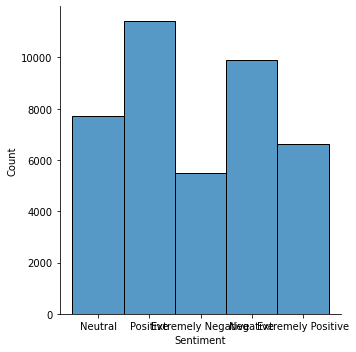

In [9]:
x1 = dataset.toPandas()
sns.displot(x1['Sentiment'])
sns.set(rc={'figure.figsize':(40,20)})

In [10]:
#Creating NLP Pipline

#Stages
tokenizer_originalTweet = Tokenizer(inputCol='OriginalTweet', outputCol='originalTweet_tokens')
stopwords_remover_originalTweet = StopWordsRemover(inputCol='originalTweet_tokens', outputCol='filtered_originalTweet')
vectorizer_originalTweet = CountVectorizer(inputCol="filtered_originalTweet",outputCol="raw_features_originalTweet")
idf_originalTweet = IDF(inputCol='raw_features_originalTweet', outputCol='vectorized_features_originalTweet')

In [11]:
#Label Encoding
labelEncoder = StringIndexer(inputCol='Sentiment', outputCol='label').fit(dataset)
dataset = labelEncoder.transform(dataset)

In [12]:
#Splitting dataset
(train_df, test_df) = dataset.randomSplit((0.7,0.3),seed=42)

In [13]:
#Building pipeline
lr = LogisticRegression(featuresCol='vectorized_features_originalTweet', labelCol='label')
pipeline = Pipeline(stages=[tokenizer_originalTweet,stopwords_remover_originalTweet,vectorizer_originalTweet,idf_originalTweet,lr])
lr_model = pipeline.fit(train_df)

In [14]:
#Prediction test data
predictions = lr_model.transform(test_df)
predictions.show()

+--------------------+------------------+-----+--------------------+----------------------+--------------------------+---------------------------------+--------------------+--------------------+----------+
|       OriginalTweet|         Sentiment|label|originalTweet_tokens|filtered_originalTweet|raw_features_originalTweet|vectorized_features_originalTweet|       rawPrediction|         probability|prediction|
+--------------------+------------------+-----+--------------------+----------------------+--------------------------+---------------------------------+--------------------+--------------------+----------+
|  A revised rail ...|          Positive|  0.0|[, , a, revised, ...|  [, , revised, rai...|      (93690,[0,5,46,88...|             (93690,[0,5,46,88...|[193.343478629558...|[1.0,3.0089464313...|       0.0|
|  Consumer Alert ...|Extremely Negative|  4.0|[, , consumer, al...|  [, , consumer, al...|      (93690,[0,10,48,1...|             (93690,[0,10,48,1...|[-47.424499702330...|[3.

In [15]:
# Import evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g " % (1.0 - accuracy))

Accuracy = 0.407693
Test Error = 0.592307 
